In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [2]:
from dgym.envs.oracle import DockingOracle
from dgym.envs.utility import ClassicUtilityFunction
from dgym.envs.designer import Designer, Generator

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 30.,
    'size_y': 30.,
    'size_z': 30.,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8.5, 10_000),
    acceptable=(6, 10_000)
)

Create selection loop.

In [83]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['ADAM17 affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library.annotated)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library.annotated)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [84]:
best = np.argsort(docking_utility.oracle(deck))[-5:]
best_molecules = deck[best]

In [90]:
from dgym.molecule import Molecule
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

molecule = Molecule(
    'Cc1cccc(-c2cccc(C(=O)NCc3ccc(F)cc3)c2)c1',
    reactants = ['NCc1ccc(F)cc1', 'Cc1cccc(-c2cccc(C(=O)O)c2)c1']
)

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = best_molecules.update_annotations(),
    assays = [docking_utility.oracle],
    budget = 100,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.3, 'size': 30}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[4, 3, 2, 1, 0]
[8, 10, 19, 4, 17]
6.140994518003976
[8, 10, 19, 17, 4]
6.140994518003976
[220, 200, 246, 271, 8]
6.307359969776324
[220, 200, 246, 271, 8]
6.307359969776324
[364, 344, 359, 327, 220]
6.531870545520588
[364, 344, 359, 327, 220]
6.531870545520588
[514, 483, 481, 364, 466]
6.643867636643015
[514, 483, 481, 364, 466]
6.643867636643015
[612, 514, 483, 481, 364]
6.709491036708397
[612, 514, 483, 481, 364]
6.709491036708397
[748, 612, 514, 483, 481]
7.013630601861461
[748, 612, 514, 483, 481]
7.013630601861461
[748, 909, 612, 953, 959]
7.013630601861461
[748, 909, 612, 953, 959]
7.013630601861461
[748, 909, 612, 1173, 1034]
7.013630601861461
[748, 909, 612, 1173, 1034]
7.013630601861461
[748, 909, 612, 1173, 1034]
7.013630601861461
[748, 909, 612, 1173, 1034]
7.013630601861461


KeyboardInterrupt: 

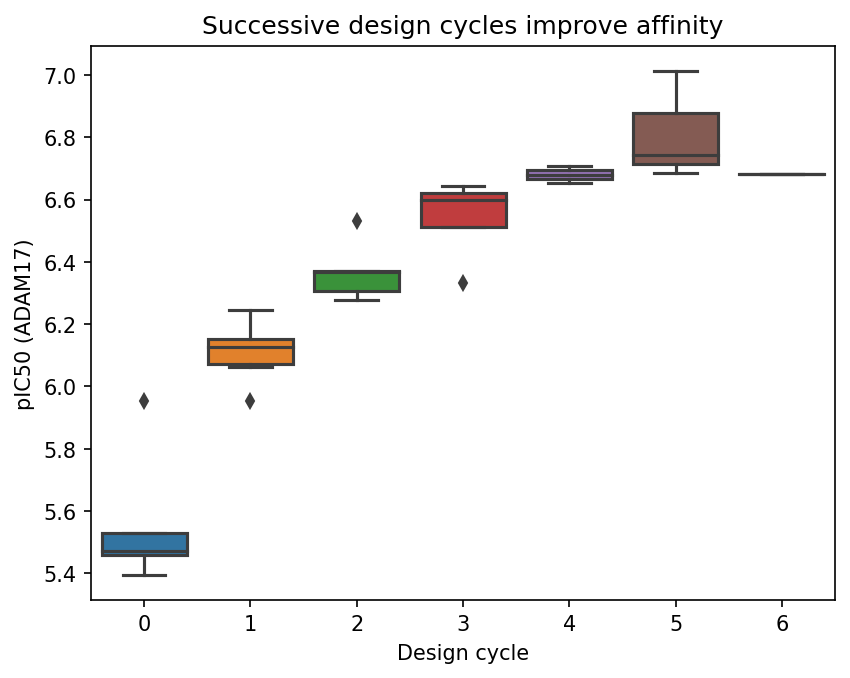

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library.annotated
g = sns.boxplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Successive design cycles improve affinity')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (ADAM17)')

plt.gcf().set_dpi(150)
plt.show()

In [108]:
docking_utility.oracle([annotated_molecules[-6]])

[7.013630601861461]

In [105]:
docking_utility.oracle(designer.design(annotated_molecules[-6], mode='expand', size=50))

[3.5848098182352084,
 5.273488153904903,
 4.744388517249292,
 4.576022269757798,
 3.8663073198140254,
 3.6506684435871306,
 4.158448160052015,
 5.579428736021519,
 4.649745434802664,
 5.3520317509244695,
 4.440926298254514,
 4.335811323886887,
 3.6855535213464963,
 3.2675657987784037,
 3.39918117592339,
 3.4970132261113496,
 4.00156128355259,
 4.499436727883983,
 4.242506076103401,
 4.082170016379534,
 3.8312291494542814,
 4.760623118670385,
 5.56284804478754,
 4.3872817655195915,
 4.5021212322948,
 5.240081462641664,
 4.637176863345087,
 4.759449943925305,
 4.181441689077414,
 3.985680944012947,
 4.795287685882836,
 5.161507002833486,
 3.3921684922909905,
 4.568788155935451,
 4.584650188635677,
 4.600657984008313,
 4.282646210381528,
 3.949455477591334,
 4.656799200160238,
 3.966108931645179,
 2.8103992351215106,
 5.8120695927335735,
 2.7641285947171044,
 nan,
 4.071493690752094,
 3.8802415925959077,
 4.823462944818653,
 nan,
 4.393606905122192,
 4.808922372387313]